In [49]:

import pandas as pd
import sys
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [50]:
sys.path.insert(0,"..")
bremen_trips = pd.read_csv("../data/processed/trips.csv")
bremen_trips = bremen_trips.sort_values(by=['start_time'], ascending=True)
bremen_trips["start_time"] = pd.to_datetime(bremen_trips["start_time"])
bremen_trips = bremen_trips[(bremen_trips['start_lng'] != bremen_trips['end_lng']) | (bremen_trips['start_lat'] != bremen_trips['end_lat'])]

In [51]:

for col in ['start_time']:
    bremen_trips['month'] = pd.DatetimeIndex(bremen_trips['start_time']).month
    bremen_trips['booking_date'] = bremen_trips.start_time.dt.date
    bremen_trips['weekdays'] = pd.DatetimeIndex(bremen_trips['start_time']).weekday

In [52]:
bremen_trips.head()


,bike,bike_type,identification,start_time,end_time,duration_sec,start_lng,start_lat,end_lng,end_lat,start_place,end_place,month,booking_date,weekdays
81821,20685,71,12099440,2019-01-20 00:13:00,2019-01-20 00:23:00,600.0,8.812554,53.076481,8.804828,53.084196,0.0,0.0,1,2019-01-20,6
204560,20935,71,7873316,2019-01-20 00:35:00,2019-01-25 08:00:00,458700.0,8.816798,53.072448,8.811472,53.083167,0.0,2946.0,1,2019-01-20,6
49030,20617,71,12099749,2019-01-20 00:40:00,2019-01-20 00:44:00,240.0,8.801623,53.067878,8.793217,53.064244,0.0,0.0,1,2019-01-20,6
131464,20795,71,12099872,2019-01-20 00:47:00,2019-01-20 00:54:00,420.0,8.814744,53.084841,8.801135,53.094596,0.0,0.0,1,2019-01-20,6
200261,20927,71,12100199,2019-01-20 01:07:00,2019-01-20 01:15:00,480.0,8.815254,53.084302,8.806666,53.094964,0.0,0.0,1,2019-01-20,6


In [53]:
# drop entries with booking durations longer than 2 days
bremen_trips = bremen_trips[bremen_trips['duration_sec'] < 5000]

In [54]:
bremen_trips['duration_min'] = bremen_trips['duration_sec']/60

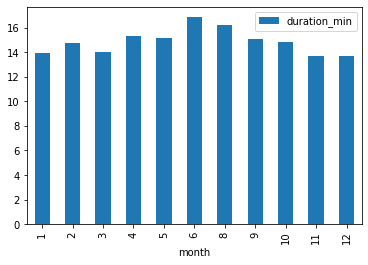

In [75]:
# avg duration per month (looks like we have some outliers)

df = bremen_trips.groupby('month').duration_min.mean().to_frame()
df.plot(kind="bar")

In [55]:
bremen_trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131731 entries, 81821 to 113816
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   bike            131731 non-null  int64         
 1   bike_type       131731 non-null  int64         
 2   identification  131731 non-null  int64         
 3   start_time      131731 non-null  datetime64[ns]
 4   end_time        131731 non-null  object        
 5   duration_sec    131731 non-null  float64       
 6   start_lng       131731 non-null  float64       
 7   start_lat       131731 non-null  float64       
 8   end_lng         131731 non-null  float64       
 9   end_lat         131731 non-null  float64       
 10  start_place     131731 non-null  float64       
 11  end_place       131731 non-null  float64       
 12  month           131731 non-null  int64         
 13  booking_date    131731 non-null  object        
 14  weekdays        131731 non-null 

In [56]:
data_raw = bremen_trips[['bike','bike_type','identification', 'start_time', 'duration_min', 'start_lng', 'start_lat', 'start_place', 'month', 'weekdays']]

In [57]:
data_raw['hour'] = data_raw['start_time'].dt.hour
data_raw['min'] = data_raw['start_time'].dt.minute
data_raw['day_of_month'] = data_raw['start_time'].dt.day
data_raw.drop(axis = 1, columns = 'start_time', inplace=True)

C:\Users\TomCLG\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\TomCLG\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\TomCLG\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [58]:
# get uniformative features meaning that they contain over 95% of the time the same value
num_rows = len(data_raw.index)
low_information_cols = [] #

for col in data_raw.columns:
    cnts = data_raw[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

bike_type: 99.88917%
71    131585
29       146
Name: bike_type, dtype: int64



In [59]:
data_raw.drop(columns=["bike_type", "identification", "bike"], inplace=True)

In [60]:
X = data_raw.loc[:, data_raw.columns != 'duration_min']
y = data_raw['duration_min']

In [61]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131731 entries, 81821 to 113816
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   start_lng     131731 non-null  float64
 1   start_lat     131731 non-null  float64
 2   start_place   131731 non-null  float64
 3   month         131731 non-null  int64  
 4   weekdays      131731 non-null  int64  
 5   hour          131731 non-null  int64  
 6   min           131731 non-null  int64  
 7   day_of_month  131731 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 9.0 MB


In [62]:
from sklearn.model_selection import train_test_split


X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.60, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.60, shuffle=False)

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [64]:
poly = PolynomialFeatures(2)
X_train_poly = poly.fit_transform(X_train)

In [65]:
lin = LinearRegression()

In [66]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.03718469561339133

In [67]:
lin.fit(X_train_poly, y_train)
lin.score(X_train_poly, y_train)

0.03718469561339133

In [68]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [69]:
parameters = {'max_depth':[2, 3, 4, 5, 7],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}
    
def perform_grid_search(X_data, y_data):
    rf = RandomForestRegressor(criterion='mse')
    
    clf = GridSearchCV(rf, parameters, cv=4, scoring='r2', n_jobs=3)
    
    clf.fit(X_data, y_data)
    
    print(clf.cv_results_['mean_test_score'])
    
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']

In [70]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)

[0.02144335 0.02273612 0.0235354  0.02392138 0.02413993 0.02422109
 0.02434027 0.02580399 0.03115591 0.03155537 0.03170298 0.03202324
 0.03191709 0.03203458 0.02278422 0.03429094 0.03527632 0.03558859
 0.03582829 0.03583163 0.03588782 0.0218843  0.03653482 0.03741356
 0.03789785 0.03817741 0.03802958 0.03808076 0.00072311 0.04004581
 0.04205309 0.04306866 0.0435781  0.04360368 0.04374109]
512 7 42


In [71]:
rf = RandomForestRegressor(criterion='mse', max_depth=depth, n_estimators=512, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=7, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=512, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [72]:
y_pred = rf.predict(X_train)

In [73]:
from sklearn.metrics import mean_squared_error

In [74]:
mean_squared_error(y_train, y_pred)

140.67564153610795